In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
df = pd.read_csv("../data/Canada_Gravity_2018.csv", comment='/')

In [29]:
days = np.unique(df['DAY'].values)

In [26]:
df_grouped_day = df.groupby('DAY')

In [36]:
df_grouped_day.get_group(day)[['X', 'Y', 'ADJG', 'DAY']].to_csv('fime_demo.csv', index=False)

In [40]:
xy = df[['X', 'Y']].values



In [47]:
from ipywidgets import widgets, interact

In [48]:
day = days[5]
def foo(day):
    df_tmp_group = df_grouped_day.get_group(day)[['X', 'Y', 'ADJG', 'DAY']]
    xy_tmp = df_tmp_group[['X', 'Y']].values
    
    
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    ax.plot(xy[:,0], xy[:,1], ',')
    ax.plot(xy_tmp[:,0], xy_tmp[:,1], 'ro')
    ax.set_aspect(1)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(day)
interact(foo, day=widgets.Select(options=days))

interactive(children=(Select(description='day', options=('01-APR-1965', '01-APR-1969', '01-APR-1970', '01-APR-…

<function __main__.foo(day)>

In [49]:
number_of_points = xy.shape[0]
number_of_points / 1e5

7.16957

In [50]:
gdf = gpd.read_file("../data/canadian-shield_1266.geojson")

<Axes: >

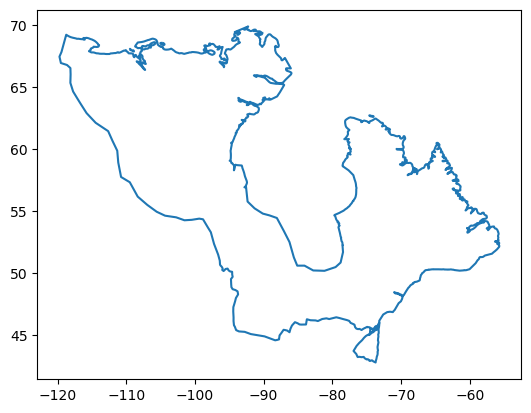

In [53]:
gdf.boundary.plot()

In [54]:
# gdf_canada = gpd.read_file("../data/lpr_000b21a_e/lpr_000b21a_e.shp")
# gdf_canada.boundary.plot()

In [55]:
# !pip install geopandas==0.14.4

In [60]:
from ipywidgets import widgets, interact
names = list(df.keys() )

In [61]:
inds = df['BOUGUER'].values<2000.

In [62]:
# out = plt.hist(df['BOUGUER'].values)

In [63]:
def foo(name, n_skip):
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    out = ax.scatter(
        xy[inds,0][::n_skip], xy[inds,1][::n_skip], s=1, c=df[name].values[inds][::n_skip], 
        cmap='turbo', 
        # vmin=-215.6, vmax=242.6
    )
    gdf.boundary.plot(ax=ax, color='red')
    plt.colorbar(out)
    ax.set_aspect(1)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(name)
    
interact(foo, name=widgets.Select(options=names, value='BOUGUER'), n_skip=widgets.IntSlider(min=1, max=20, step=1, value=5))

interactive(children=(Select(description='name', index=4, options=('X', 'Y', 'ADJG', 'B_ERR', 'BOUGUER', 'COOR…

<function __main__.foo(name, n_skip)>

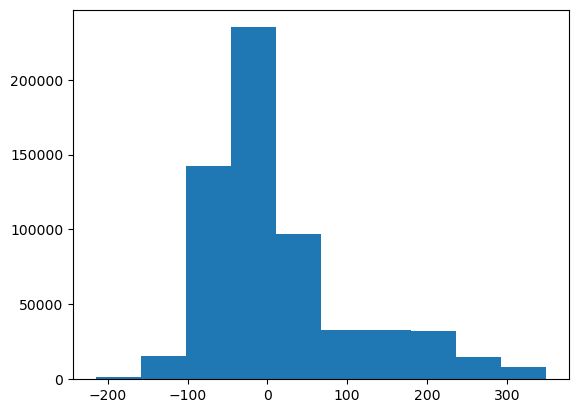

In [64]:
out = plt.hist(df['BOUGUER'].values[df['BOUGUER'].values<2000.])

In [67]:
# fig, ax = plt.subplots(1,1, figsize=(10, 5))
# out = ax.scatter(xy[::nskip,0], xy[::nskip,1], s=1, c=df[name].values[::nskip])
# gdf.boundary.plot(ax=ax, color='red')
# plt.colorbar(out)
# ax.set_aspect(1)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# ax.set_title(name)


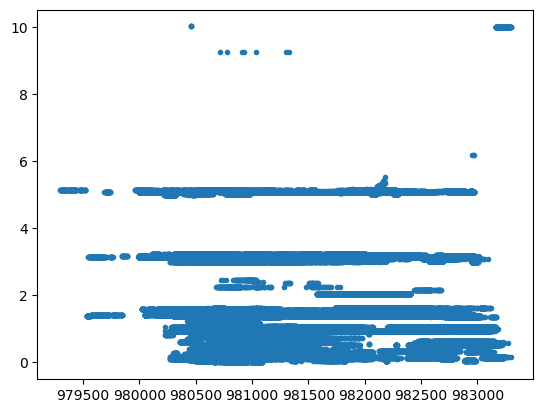

In [68]:
# plt.plot(df['ADJG'].values-df['FA_ERR'].values, df['Y'].values)
plt.plot(df['ADJG'].values, df['FA_ERR'].values, '.')
# plt.plot(df['FREEAIR'].values, df['Y'].values)

In [69]:
widgets.RadioButtons?

Init signature: widgets.RadioButtons(*args: 't.Any', **kwargs: 't.Any') -> 't.Any'
Docstring:     
Group of radio buttons that represent an enumeration.

Only one radio button can be toggled at any point in time.

Parameters
----------
options: list
    The options for the dropdown. This can either be a list of values, e.g.
    ``['Galileo', 'Brahe', 'Hubble']`` or ``[0, 1, 2]``, a list of
    (label, value) pairs, e.g.
    ``[('Galileo', 0), ('Brahe', 1), ('Hubble', 2)]``, or a Mapping between
    labels and values, e.g., ``{'Galileo': 0, 'Brahe': 1, 'Hubble': 2}``.

index: int
    The index of the current selection.

value: any
    The value of the current selection. When programmatically setting the
    value, a reverse lookup is performed among the options to check that
    the value is valid. The reverse lookup uses the equality operator by
    default, but another predicate may be provided via the ``equals``
    keyword argument. For example, when dealing with numpy arrays, one m

In [77]:
def get_normal_gravity(phi_degree, e2=0.00669438002290, k=0.001931851353, gamma_e=978032.67715):
    phi = np.deg2rad(phi_degree)
    sin2 = np.sin(phi)**2
    gamma_phi = gamma_e * (1+k*sin2) / (np.sqrt(1-e2*sin2))
    return gamma_phi

In [86]:
free_air_correction = get_normal_gravity(xy[:,1])  - 0.3086 * df['ELEV'].values

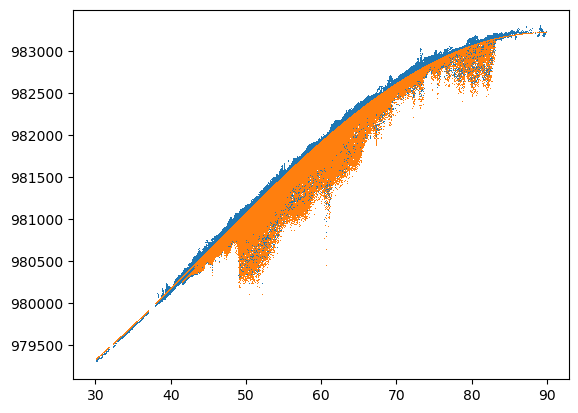

In [87]:

plt.plot(xy[:,1], df['ADJG'].values, ',')
plt.plot(xy[:,1], free_air_correction, ',')

Text(642.3371785090601, 0.5, 'Latitude')

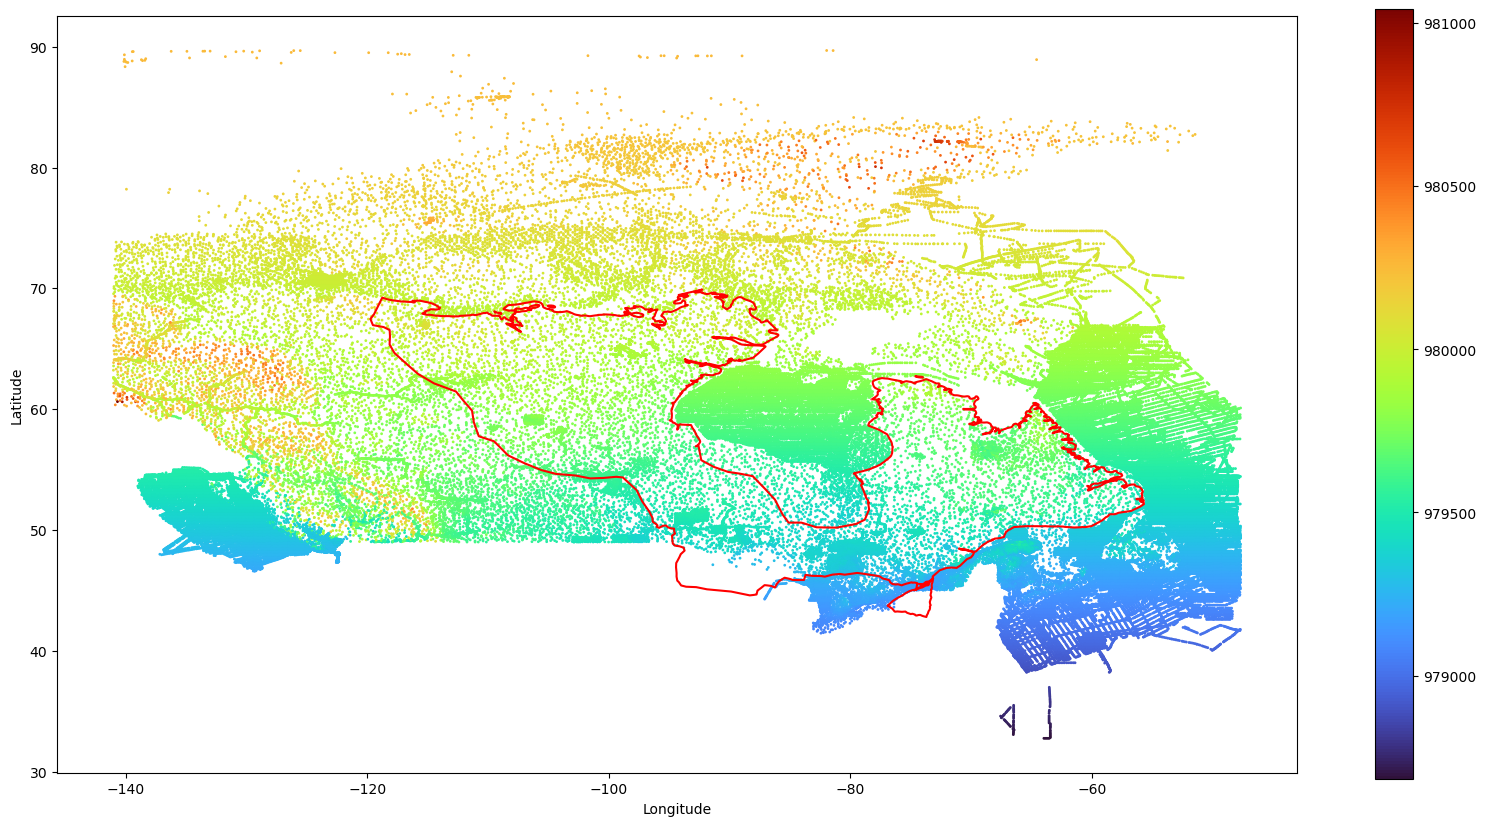

In [25]:
nskip = 5
fig, ax = plt.subplots(1,1, figsize=(20, 10))
out = ax.scatter(
    xy[inds,0][::nskip], xy[inds,1][::nskip], s=1, c=free_air_correction[inds][::nskip], 
    cmap='turbo', 
    # vmin=-215.6, vmax=242.6
)
gdf.boundary.plot(ax=ax, color='red')
plt.colorbar(out)
ax.set_aspect(1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.set_title(name)


In [3]:
df.shape

(716957, 22)

In [4]:
header ='X,Y,ADJG,B_ERR,BOUGUER,COORD_ERR,DAY,DEPTH,DEPTH_ERR,DEPTH_TYPE,ELEV,ELEV_ERR,FA_ERR,FREEAIR,G_ERR,PROJ,STATUS,STN,STN_TYPE,TC,TC_ERR,TIM'.split(',')

In [5]:
df.head(3)

,X,Y,ADJG,B_ERR,BOUGUER,COORD_ERR,DAY,DEPTH,DEPTH_ERR,DEPTH_TYPE,...,FA_ERR,FREEAIR,G_ERR,PROJ,STATUS,STN,STN_TYPE,TC,TC_ERR,TIME
-63.961270,30.470851,979342.46,0.0,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-19.41,5.0,1970702,1,501662,21,0.0,0.0,618,NaN
-63.961571,30.454652,979344.38,0.0,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-16.21,5.0,1970702,1,501667,21,0.0,0.0,623,NaN
-63.961770,30.438452,979344.20,0.0,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-15.11,5.0,1970702,1,501672,21,0.0,0.0,628,NaN


In [11]:
len(header)

22

In [12]:
df

,X,Y,ADJG,B_ERR,BOUGUER,COORD_ERR,DAY,DEPTH,DEPTH_ERR,DEPTH_TYPE,...,FA_ERR,FREEAIR,G_ERR,PROJ,STATUS,STN,STN_TYPE,TC,TC_ERR,TIME
-63.961270,30.470851,979342.46,0.00,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-19.41,5.0,1970702,1,501662,21,0.0,0.0,618,NaN
-63.961571,30.454652,979344.38,0.00,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-16.21,5.0,1970702,1,501667,21,0.0,0.0,623,NaN
-63.961770,30.438452,979344.20,0.00,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-15.11,5.0,1970702,1,501672,21,0.0,0.0,628,NaN
-63.961972,30.422253,979346.25,0.00,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-11.79,5.0,1970702,1,501677,21,0.0,0.0,633,NaN
-63.962170,30.406053,979344.43,0.00,9999.99,1000.0,17-JAN-1970,0.0,0.0,0,0.0,...,-12.33,5.0,1970702,1,501682,21,0.0,0.0,638,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-88.761157,89.248049,983221.40,10.59,177.70,100.0,01-JAN-1901,2525.0,50.5,5,0.3,...,3.75,10.0,1979104,1,4154,24,0.0,0.0,0,NaN
-89.318858,89.246381,983221.10,10.59,177.67,100.0,01-JAN-1901,2528.9,50.6,5,0.3,...,3.46,10.0,1979104,1,4155,24,0.0,0.0,0,NaN
-64.583377,88.932935,983186.20,4.01,168.24,400.0,16-APR-1969,2886.8,57.7,5,0.0,...,-30.63,0.5,1969105,1,4017,24,0.0,0.0,704,NaN
-56.980008,88.001144,983267.80,1.75,138.02,400.0,16-APR-1969,1197.9,24.0,5,0.0,...,55.50,0.5,1969105,1,4018,24,0.0,0.0,830,NaN
